# 1. Install Dependencies and Setup

In [2]:
!pip install tensorflow tensorflow-gpu opencv-python matplotlib

  Using cached termcolor-1.1.0.tar.gz (3.9 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
  Using cached opt_einsum-3.3.0-py3-none-any.whl (65 kB)
  Using cached Keras_Preprocessing-1.1.2-py2.py3-none-any.whl (42 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl (57 kB)
  Using cached tensorboard_data_server-0.6.1-py3-none-any.whl (2.4 kB)
  Using cached pyasn1_modules-0.2.8-py2.py3-none-any.whl (155 kB)
  Using cached pyasn1-0.4.8-py2.py3-none-any.whl (77 kB)
  Created wheel for termcolor: filename=termcolor-1.1.0-py3-none-any.whl size=4848 sha256=fcebd0d19935b83365a7ba07aa8d80f3d875f6ecaa6d5f66a1ffdfbfbb2f38b8
  Stored in directory: c:\users\gowth\appdata\local\pip\cache\wheels\a1\49\46\1b13a65d8da11238af9616b00fdde6d45b0f95d9291bac8452
Successfully built termcolor


In [3]:
!pip list

Package                      Version
---------------------------- -------------------
absl-py                      1.0.0
anyio                        3.5.0
argon2-cffi                  21.3.0
argon2-cffi-bindings         21.2.0
asttokens                    2.0.5
astunparse                   1.6.3
attrs                        21.4.0
Babel                        2.9.1
backcall                     0.2.0
beautifulsoup4               4.11.1
bleach                       4.1.0
brotlipy                     0.7.0
cachetools                   5.0.0
certifi                      2021.10.8
cffi                         1.15.0
charset-normalizer           2.0.12
colorama                     0.4.4
cryptography                 36.0.2
cycler                       0.11.0
debugpy                      1.5.1
decorator                    5.1.1
defusedxml                   0.7.1
entrypoints                  0.4
executing                    0.8.3
fastjsonschema               2.15.1
flatbuffers                 

In [6]:
import tensorflow as tf
import os

In [7]:
gpus = tf.config.experimental.list_physical_devices('GPU')

for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [8]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# 2. Remove dodgy images

In [9]:
import cv2
import imghdr

In [10]:
data_dir = 'data'

In [11]:
image_exts  = ['jpeg', 'jgp', 'bmp', 'png']

In [12]:
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts:
                print(f'Image not in ext list ${image_path}')
                os.remove(image_path)
        except Exception as e:
            print(f'Issue with image ${image_path}')

# 3. Load Data

In [13]:
import numpy as np
from matplotlib import pyplot as plt

In [14]:
data = tf.keras.utils.image_dataset_from_directory('data')

Found 305 files belonging to 2 classes.


In [15]:
data_iterator = data.as_numpy_iterator()

In [16]:
batch = data_iterator.next()

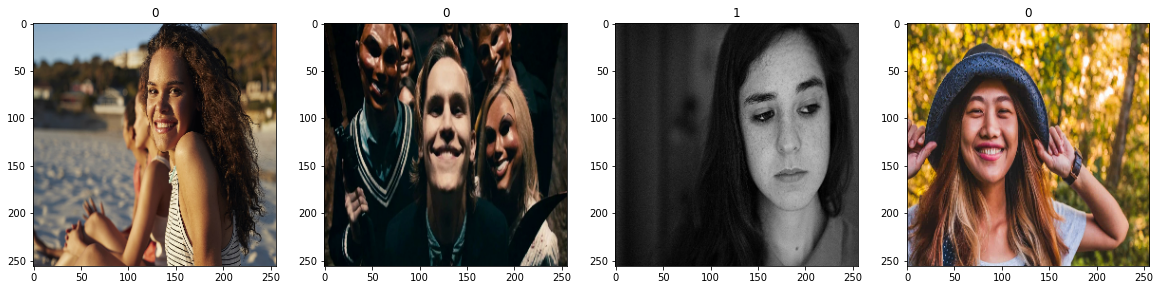

In [17]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# 4. Scale Data

In [18]:
# neural networks works well on down scaled data
data = data.map(lambda x, y: (x/255, y))

In [19]:
data.as_numpy_iterator().next()

(array([[[[1.01960786e-01, 9.80392173e-02, 7.84313753e-02],
          [1.01960786e-01, 9.80392173e-02, 7.84313753e-02],
          [1.01960786e-01, 9.80392173e-02, 7.84313753e-02],
          ...,
          [1.93895534e-01, 1.97817102e-01, 1.78209245e-01],
          [1.89108461e-01, 1.93030030e-01, 1.73422188e-01],
          [1.76907167e-01, 1.80828735e-01, 1.61220893e-01]],
 
         [[1.01960786e-01, 9.80392173e-02, 7.84313753e-02],
          [1.01960786e-01, 9.80392173e-02, 7.84313753e-02],
          [1.01960786e-01, 9.80392173e-02, 7.84313753e-02],
          ...,
          [1.93895534e-01, 1.97817102e-01, 1.78209245e-01],
          [1.89108461e-01, 1.93030030e-01, 1.73422188e-01],
          [1.76907167e-01, 1.80828735e-01, 1.61220893e-01]],
 
         [[1.01960786e-01, 9.80392173e-02, 7.84313753e-02],
          [1.01960786e-01, 9.80392173e-02, 7.84313753e-02],
          [1.01960786e-01, 9.80392173e-02, 7.84313753e-02],
          ...,
          [1.94104433e-01, 1.98026001e-01, 1.7841

# 5. Split Data

In [20]:
train_size = int(len(data) * 0.7)
val_size = int(len(data) * 0.2)
test_size = int(len(data) * 0.1)

In [21]:
train_size

7

In [22]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size + val_size).take(test_size)

In [23]:
train

<TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

# 6. Build Deep Learning Model

In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [25]:
model = Sequential()

In [26]:
model.add(Conv2D(16, (3, 3), 1, activation='relu', input_shape=(256, 256, 3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3, 3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3, 3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [27]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 16)       0

# 7. Train

In [30]:
logdir='logs'

In [31]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [32]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
7/7 [==============================] - 25s 353ms/step - loss: 0.8795 - accuracy: 0.5179 - val_loss: 0.6852 - val_accuracy: 0.7188
Epoch 2/20
7/7 [==============================] - 3s 310ms/step - loss: 0.6660 - accuracy: 0.6875 - val_loss: 0.5754 - val_accuracy: 0.7656
Epoch 3/20
7/7 [==============================] - 3s 303ms/step - loss: 0.5626 - accuracy: 0.7500 - val_loss: 0.5674 - val_accuracy: 0.7031
Epoch 4/20
7/7 [==============================] - 3s 305ms/step - loss: 0.4406 - accuracy: 0.8125 - val_loss: 0.4669 - val_accuracy: 0.8125
Epoch 5/20
7/7 [==============================] - 3s 305ms/step - loss: 0.3862 - accuracy: 0.8348 - val_loss: 0.2592 - val_accuracy: 0.9375
Epoch 6/20
7/7 [==============================] - 3s 303ms/step - loss: 0.3208 - accuracy: 0.8750 - val_loss: 0.2873 - val_accuracy: 0.9375
Epoch 7/20
7/7 [==============================] - 3s 300ms/step - loss: 0.2132 - accuracy: 0.9286 - val_loss: 0.1925 - val_accuracy: 0.9531
Epoch 8/20
7/7 [===

# 8. Plot Performance

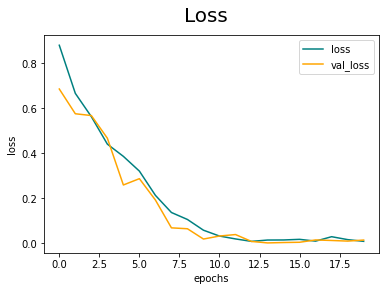

In [37]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
plt.xlabel('epochs')
plt.ylabel('loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc='upper right')
plt.show()

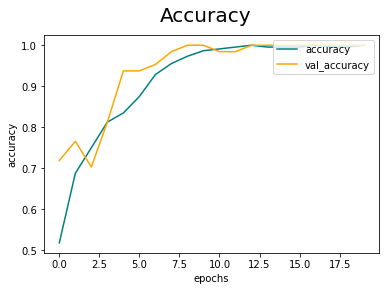

In [38]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc='upper right')
plt.show()

# 9. Evaluate

In [39]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [40]:
precision, recall, accuracy = Precision(), Recall(), BinaryAccuracy()

In [41]:
for batch in test.as_numpy_iterator():
    X, y = batch
    y_hat = model.predict(X)
    precision.update_state(y, y_hat)
    recall.update_state(y, y_hat)
    accuracy.update_state(y, y_hat)

In [42]:
print(precision.result(), recall.result(), accuracy.result())

tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32)


# 10. Test

In [43]:
import cv2

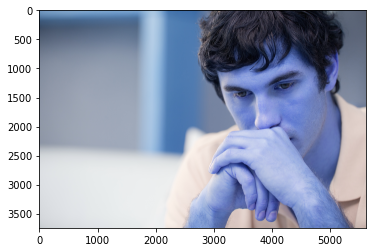

In [58]:
img = cv2.imread('8iAb9k4aT.jpg')
plt.imshow(img)

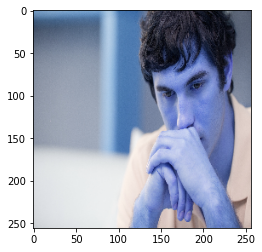

In [59]:
resize = tf.image.resize(img, (256, 256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [60]:
y_hat = model.predict(np.expand_dims(resize/255, 0))
y_hat

array([[0.99900997]], dtype=float32)

In [61]:
if y_hat > 0.5:
    print(f'Predicted class: Sad')
else:
    print(f'Predicted class: Happy')

Predicted class: Sad


# 11. Save the Model

In [63]:
from tensorflow.keras.models import load_model

In [64]:
model.save(os.path.join('models', 'imageclassifier.h5'))

In [67]:
new_model = load_model(os.path.join('models', 'imageclassifier.h5'))

In [ ]:
new